# Assessment of the resolution capability of SLSTR AOD (1°) to identify pollution hotspots (2018–2022).

&nbsp;

Production date: 30-09-2024

Produced by: University of Salerno (UNISA)- (Fabio Madonna and Faezeh Karimian)

## 🌍 Use case: Identification of Pollution Hotspots
## ❓ Quality assessment questions

**• Is there a difference in the aerosol optical depth (AOD) between megacities and nearby towns?**

**• How satellite AOD can be used as a proxy for local air pollution when comparing scales of tens of kilometers?** 

The satellite-aerosol-properties catalog provides global Aerosol Optical Depth (AOD) and fine-mode AOD (FMAOD) from 1995 to present. AOD is often used as a proxy for particulate pollution, but being representative of the entire atmospheric column and influenced by different sources at different atmospheric levels, may be not able to capture change in the local air pollution [1]. Moreover, several products are at horizonal resolutions coarser than what is required to capture local difference due to pollution sources. Europe, where most citizens are exposed to air pollution levels above WHO guidelines [2], provides a relevant and challenging case study for evaluating satellite-based aerosol observations.
In this analysis we use the SLSTR ensemble product to produce seasonal maps of AOD and FMAOD over the investigated period, with major cities such as Milan, Brussels, London, and Athens marked for context. These maps provide a regional overview of spatial patterns and seasonal variability. In addition, we retain line plots only for selected hotspots (e.g., Brussels, Milan, London) to illustrate how AOD and FMAOD values evolve over time at the city scale and also to show the difference in the AOD and FMAOD between megacities and nearby towns. This combination of maps and targeted time series balances spatial coverage with local detail, while keeping the focus on how satellite products can inform—but also constrain—urban air-quality assessments.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note


• The seasonal maps confirm broad regional patterns in AOD and FMAOD, with higher values in summer (JJA) and spring (MAM) and lower values in winter (DJF). This seasonal cycle is consistent with enhanced photochemical activity, transport of natural aerosols, and regional meteorology.

• Pairwise comparisons between megacities and their nearby towns reveal only modest differences. For Athens, mean AOD in the city is slightly higher than in Livadeia, but for Brussels, London, and Milan the rural sites often show equal or even slightly higher values.

• These small differences highlight that, at ~1° resolution, satellite AOD tends to represent regional-scale aerosol burdens rather than sharp urban hotspots. The fractional statistics support this: for example, Athens shows the city having higher AOD than the rural site in ~68% of months, while in Brussels and London the nearby towns often exceed the city.

• A small data gap is present for Northampton, which reduces the seasonal coverage. However, the available months are sufficient to capture the main seasonal cycle, so the results remain representative but should be interpreted with caution.

• Taken together, these findings emphasize the importance of scale and representativity. While satellite AOD products capture regional patterns and seasonality well, they cannot be expected to resolve contrasts between neighboring urban and rural sites at the scale of tens of kilometers.

## 📋 Methodology

This assessment aims to assess the consistency and completeness of SLSTR-derived satellite data in capturing the seasonal variability of Aerosol Optical Depth (AOD) over different global regions from 2018 to 2023. We also quantifyed data completeness via monthly observation counts normalized by area, and  test urban–rural contrasts using grid-aware neighborhoods.

The methodology adopted for the analysis is split into the following steps:

[](section-1) 
* Import all required libraries  
* Spatial and temporal definitions
  
[](section-2)  
* Download AOD data
* Prepare the dataframe
* Define required functions
* 
[](section-3)  
* Pairwise monthly differences (city − nearby town)
* Seasonal means (climatological) per pair
* City–rural AOD and FM-AOD time-series plots
* Seasonal AOD & FM-AOD maps (with city/rural markers)
* Focused seasonal map plots of AOD550 and FM_AOD550 for megacity–town pairs

[](section-4) 

## 📈 Analysis and results
(section-1)=
### Choose the data to use and set up the code
#### Import all required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [57]:
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
warnings.filterwarnings("ignore")
from pathlib import Path
import matplotlib.gridspec as gridspec


#### Spatial and temporal definitions

This assessment analyzes monthly SLSTR/Sentinel-3 AOD and FMAOD from July 2018 to December 2023, focusing on selected European megacities and their nearby towns. Four paired Areas of Interest (AOIs) are defined: Athens–Livadeia (Greece), London–Northampton (United Kingdom), Brussels–Arras (Belgium), and Milan–Sondrio (Italy). These AOIs are based on fixed latitude/longitude coordinates and represent typical urban–rural contrasts within ~100 km distance.

In [58]:
EUROPE_EXTENT = (-12, 35, 34, 60) 
YEAR_START, YEAR_END = 2018, 2022
AOIS = {
    # Greece
    "Athens (megacity)":       {"lat": 37.9838, "lon": 23.7275, "kind": "city"},
    "Livadeia (nearby rural)": {"lat": 38.4350, "lon": 22.8760, "kind": "rural"},  # ~95 km
     # UK
    "London (megacity)":         {"lat": 51.5074, "lon": -0.1278, "kind": "city"},
    "Northampton (nearby town)": {"lat": 52.2405, "lon": -0.9027, "kind": "rural"},  # ~97 km

    # Belgium
    "Brussels (megacity)":       {"lat": 50.8466, "lon": 4.3528,  "kind": "city"},
    "Arras (nearby town)":       {"lat": 50.2910, "lon": 2.7770,  "kind": "rural"},  # ~92 km WSW

    # Italy
    "Milan (megacity)":          {"lat": 45.4642, "lon": 9.1900,  "kind": "city"},
    "Sondrio (nearby town)":     {"lat": 46.1690, "lon": 9.8710,  "kind": "rural"},  # ~96 km N
}

PAIRS = [
    ("Athens (megacity)",      "Livadeia (nearby rural)"),
    ("London (megacity)",   "Northampton (nearby town)"),
    ("Brussels (megacity)", "Arras (nearby town)"),
    ("Milan (megacity)",    "Sondrio (nearby town)"),
]

(section-2)=
### Data Retrieval and Preparation
Below are robust, grid-aware functions and the city/rural time-series computation.

#### Download AOD data

In [59]:
folder_path = "./aod_data" 

file_list = sorted([
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith('.nc')
])

print(f"Found {len(file_list)} .nc files")
for f in file_list[:5]:  
    print(f)

df_list = []
file_list = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.nc')])
df_list = []

for file in file_list:
    ds = xr.open_dataset(file)
    timestamp = pd.to_datetime(os.path.basename(file)[:6], format='%Y%m')
    ds = ds.expand_dims({'time': [timestamp]})
    df = ds.to_dataframe().reset_index()
    df_list.append(df)

final_df = pd.concat(df_list, ignore_index=True)
final_df.replace(-999.0, pd.NA, inplace=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)
print(final_df)

Found 66 .nc files
./aod_data/201801-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201802-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201803-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201804-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
./aod_data/201805-C3S-L3_AEROSOL-AER_PRODUCTS-SLSTR-SENTINEL3A-ensemble-MONTHLY-v2.3.nc
              time  latitude  longitude    AOD550  FM_AOD550  \
0       2018-01-01     -89.5     -179.5       NaN        NaN   
43192   2018-01-01      29.5      172.5  0.123682   0.049830   
43193   2018-01-01      29.5      173.5  0.116795   0.043411   
43194   2018-01-01      29.5      174.5  0.188018   0.079148   
43195   2018-01-01      29.5      175.5  0.058454   0.015076   
...            ...       ...        ...       ...        ...   
4233604 2023-06-01     -29.5     -175.5  0.076325   0.047782   
4233605 2023-06-01     -29.5 

#### Prepare the dataframe

In [60]:
df_eu = subset_df(final_df, year_start=YEAR_START, year_end=YEAR_END, extent=EUROPE_EXTENT)
df_eu = add_season_cols(df_eu)
seasonal = seasonal_means(df_eu, value_cols=("AOD550","FM_AOD550"))

#### Define required functions

In [79]:
def month_to_season(m):
    # DJF, MAM, JJA, SON
    if m in (12, 1, 2):
        return "DJF"
    elif m in (3, 4, 5):
        return "MAM"
    elif m in (6, 7, 8):
        return "JJA"
    else:
        return "SON"

def add_season_cols(df):
    df = df.copy()
    df["year"] = df["time"].dt.year
    df["month"] = df["time"].dt.month
    df["season"] = df["month"].apply(month_to_season)
   
    df["season_year"] = df["year"]
    df.loc[df["month"] == 12, "season_year"] = df["year"] + 1
    return df


def subset_df(df, year_start=None, year_end=None, extent=None):
    sub = df.copy()
    if year_start is not None:
        sub = sub[sub["time"].dt.year >= year_start]
    if year_end is not None:
        sub = sub[sub["time"].dt.year <= year_end]
    if extent is not None:
        w, e, s, n = extent
        sub = sub[(sub["longitude"] >= w) & (sub["longitude"] <= e) &
                  (sub["latitude"]  >= s) & (sub["latitude"]  <= n)]
    return sub


def seasonal_means(df, value_cols=("AOD550", "FM_AOD550")):
    # drop entirely NaN rows for both vars
    keep = df.copy()
    # group per (season_year, season, lat, lon)
    grp = keep.groupby(["season_year","season","latitude","longitude"], as_index=False)[list(value_cols)].mean()
    return grp


def grid_for_plot(df_season, var):
    
    grid = df_season.pivot_table(index="latitude", columns="longitude", values=var, aggfunc="mean")
    lats = grid.index.values
    lons = grid.columns.values

    dlat = np.median(np.diff(lats)) if len(lats) > 1 else 1.0
    dlon = np.median(np.diff(lons)) if len(lons) > 1 else 1.0
    lat_edges = np.concatenate(([lats[0]-dlat/2], (lats[:-1]+lats[1:])/2, [lats[-1]+dlat/2]))
    lon_edges = np.concatenate(([lons[0]-dlon/2], (lons[:-1]+lons[1:])/2, [lons[-1]+dlon/2]))
    return lon_edges, lat_edges, grid.values

import matplotlib.gridspec as gridspec

def plot_seasonal_maps(seasonal_df, var, season_year=None, cmap="viridis",
                       vmin=None, vmax=None, extent=EUROPE_EXTENT, title_suffix=""):

    df = seasonal_df.copy()
    if season_year is not None:
        df = df[df["season_year"] == season_year]
    else:
        df = df.groupby(["season","latitude","longitude"], as_index=False)[var].mean()

    seasons = ["DJF","MAM","JJA","SON"]
    proj = ccrs.PlateCarree()


    fig = plt.figure(figsize=(15, 9))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,0.05])  

    axes = []
    for i in range(2):
        for j in range(2):
            ax = fig.add_subplot(gs[i, j], projection=proj)
            axes.append(ax)

    for ax, s in zip(axes, seasons):
        sub = df[df["season"] == s]
        if sub.empty:
            ax.set_title(f"{s} (no data)")
            ax.coastlines(); ax.add_feature(cfeature.BORDERS, linewidth=0.4)
            ax.set_extent(extent, crs=proj); continue

        lon_edges, lat_edges, Z = grid_for_plot(sub, var)

        mesh = ax.pcolormesh(lon_edges, lat_edges, Z, transform=proj,
                             cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black", linewidth=0.2)
        ax.set_extent(extent, crs=proj)
        ax.set_title(f"{s}")

        for name, info in AOIS.items():
            if (extent[0] <= info["lon"] <= extent[1]) and (extent[2] <= info["lat"] <= extent[3]):
                mk = "s" if info["kind"] == "city" else "o"
                ax.plot(info["lon"], info["lat"], mk, transform=proj, ms=5, mec="k", mfc="none")
                ax.text(info["lon"]+0.3, info["lat"]+0.3, name.split(" (")[0],
                        transform=proj, fontsize=8)

    cax = fig.add_subplot(gs[:, 2])
    cbar = fig.colorbar(mesh, cax=cax)
    cbar.set_label(var)

    title_year = f"{season_year}" if season_year is not None else "Climatology"
    fig.suptitle(f"SLSTR seasonal mean {var} — {title_year} {title_suffix}", y=0.95, fontsize=14)

    plt.tight_layout(rect=[0,0,0.93,0.95])
    return fig






def global_color_limits(seasonal_df, var, lo=5, hi=95):
    vals = seasonal_df[var].to_numpy()
    return (np.nanpercentile(vals, lo), np.nanpercentile(vals, hi))

def subset_seasonal_box(seasonal_df, extent):
    w,e,s,n = extent
    return seasonal_df[
        (seasonal_df["longitude"]>=w) & (seasonal_df["longitude"]<=e) &
        (seasonal_df["latitude"] >=s) & (seasonal_df["latitude"] <=n)
    ]

def grid_for_plot(df_season, var):
    grid = df_season.pivot_table(index="latitude", columns="longitude", values=var, aggfunc="mean")
    lats = grid.index.values
    lons = grid.columns.values
    dlat = np.median(np.diff(lats)) if len(lats)>1 else 1.0
    dlon = np.median(np.diff(lons)) if len(lons)>1 else 1.0
    lat_edges = np.concatenate(([lats[0]-dlat/2], (lats[:-1]+lats[1:])/2, [lats[-1]+dlat/2]))
    lon_edges = np.concatenate(([lons[0]-dlon/2], (lons[:-1]+lons[1:])/2, [lons[-1]+dlon/2]))
    return lon_edges, lat_edges, grid.values


if 'df_eu' not in globals():
  
    EUROPE_EXTENT = (-12, 35, 34, 60)
    df_eu = final_df[
        (final_df['longitude']>=EUROPE_EXTENT[0]) & (final_df['longitude']<=EUROPE_EXTENT[1]) &
        (final_df['latitude'] >=EUROPE_EXTENT[2]) & (final_df['latitude'] <=EUROPE_EXTENT[3])
    ].copy()
    df_eu = df_eu[(df_eu['time'].dt.year>=2018) & (df_eu['time'].dt.year<=2022)]
    df_eu = df_eu.assign(month=df_eu['time'].dt.month,
                         year=df_eu['time'].dt.year)
    def m2s(m):
        return "DJF" if m in (12,1,2) else ("MAM" if m in (3,4,5) else ("JJA" if m in (6,7,8) else "SON"))
    df_eu['season'] = df_eu['month'].apply(m2s)
    df_eu['season_year'] = df_eu['year']
    df_eu.loc[df_eu['month']==12,'season_year'] = df_eu['year']+1

seasonal = (df_eu
            .groupby(["season_year","season","latitude","longitude"], as_index=False)
            [["AOD550","FM_AOD550"]].mean())

aod_vmin, aod_vmax = global_color_limits(seasonal, "AOD550", 5, 95)
fm_vmin,  fm_vmax  = global_color_limits(seasonal, "FM_AOD550", 5, 95)

import numpy.ma as ma

def plot_pair_focus(
    pair,
    var="AOD550",
    cmap="YlOrRd",
    vmin=None,
    vmax=None,
    pad_deg=0.25,  
    title_suffix="Climatology (2018–2022)"
):
    city, town = pair
    c = AOIS[city]; r = AOIS[town]

 
    clim = seasonal.groupby(["season","latitude","longitude"], as_index=False)[var].mean()

 
    w = min(c["lon"], r["lon"]) - pad_deg
    e = max(c["lon"], r["lon"]) + pad_deg
    s = min(c["lat"], r["lat"]) - pad_deg
    n = max(c["lat"], r["lat"]) + pad_deg
    box = subset_seasonal_box(clim, (w, e, s, n))


    if not box.empty:
        w = float(box["longitude"].min()) - 0.25
        e = float(box["longitude"].max()) + 0.25
        s = float(box["latitude"].min()) - 0.25
        n = float(box["latitude"].max()) + 0.25
    extent = (w, e, s, n)


    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,0.05], wspace=0.1, hspace=0.15)
    axes = [
        fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree()),
        fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree()),
    ]
    cax = fig.add_subplot(gs[:,2])


    base_cmap = plt.get_cmap(cmap).copy()
    low_col = base_cmap(0.0)
    base_cmap.set_bad(low_col)
    base_cmap.set_under(low_col)

    last_mesh = None
    for ax, season in zip(axes, ["DJF","MAM","JJA","SON"]):
        sub = box[box["season"]==season]
        ax.set_title(season)
        ax.set_extent(extent)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.set_facecolor(low_col)

        if not sub.empty:
            loE, laE, Z = grid_for_plot(sub, var)
            Z_masked = ma.masked_invalid(Z)
            last_mesh = ax.pcolormesh(loE, laE, Z_masked, cmap=base_cmap,
                                      transform=ccrs.PlateCarree(),
                                      shading="auto", vmin=vmin, vmax=vmax)

 
        ax.plot(c["lon"], c["lat"], "s", ms=6, mec="k", mfc="white", transform=ccrs.PlateCarree())
        ax.plot(r["lon"], r["lat"], "o", ms=6, mec="k", mfc="white", transform=ccrs.PlateCarree())

    if last_mesh:
        cb = fig.colorbar(last_mesh, cax=cax)
        cb.set_label(var)

    fig.suptitle(f"{var} — {city} vs {town} — {title_suffix}", y=0.97)
    plt.tight_layout(rect=[0,0,0.95,0.95])
    import matplotlib.lines as mlines


    city_marker = mlines.Line2D([], [], color="black", marker="s", linestyle="None",
                            markersize=6, label="City (megacity)")
    rural_marker = mlines.Line2D([], [], color="black", marker="o", linestyle="None",
                             markersize=6, label="Rural (nearby town)")

    fig.legend(handles=[city_marker, rural_marker], loc="lower center", ncol=2, frameon=False)

    return fig, extent



def ensure_monthly(df):
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"]).dt.to_period("M").dt.to_timestamp()
    return df

final_df = ensure_monthly(final_df)


def aoi_monthly_series(df, lat, lon, halfwin=0.5):
    sub = df[
        (df["latitude"].between(lat - halfwin, lat + halfwin)) &
        (df["longitude"].between(lon - halfwin, lon + halfwin))
    ]
    ser = (sub
           .groupby("time", as_index=False)[["AOD550","FM_AOD550","NMEAS"]]
           .mean()) 
    ser = ser.sort_values("time").reset_index(drop=True)
    return ser

def build_pair_df(df, city_name, town_name, halfwin=0.5):
    c = AOIS[city_name]; t = AOIS[town_name]
    city = aoi_monthly_series(df, c["lat"], c["lon"], halfwin).rename(
        columns={"AOD550":"AOD_city", "FM_AOD550":"FM_city", "NMEAS":"N_city"})
    town = aoi_monthly_series(df, t["lat"], t["lon"], halfwin).rename(
        columns={"AOD550":"AOD_town", "FM_AOD550":"FM_town", "NMEAS":"N_town"})
    merged = pd.merge(city[["time","AOD_city","FM_city"]],
                      town[["time","AOD_town","FM_town"]],
                      on="time", how="outer").sort_values("time")

    for col in ["AOD_city","AOD_town","FM_city","FM_town"]:
        merged[col+"_roll3"] = merged[col].rolling(3, center=True, min_periods=1).mean()
 
    merged["AOD_diff"] = merged["AOD_city"] - merged["AOD_town"]
    merged["FM_diff"]  = merged["FM_city"]  - merged["FM_town"]
    return merged


def plot_pair_timeseries(pair_df, city_name, town_name, year_start=2018, year_end=2022):
 
    mask = (pair_df["time"].dt.year >= year_start) & (pair_df["time"].dt.year <= year_end)
    dfp = pair_df.loc[mask].copy()

    aod_pct = np.round(100*np.nanmean(dfp["AOD_diff"] > 0), 1)
    fm_pct  = np.round(100*np.nanmean(dfp["FM_diff"]  > 0), 1)
    aod_md  = np.nanmean(dfp["AOD_diff"])
    fm_md   = np.nanmean(dfp["FM_diff"])

    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    ax1, ax2 = axes

    ax1.plot(dfp["time"], dfp["AOD_city"], lw=1, alpha=0.4, label=f"{city_name} (monthly)")
    ax1.plot(dfp["time"], dfp["AOD_town"], lw=1, alpha=0.4, label=f"{town_name} (monthly)")
    ax1.plot(dfp["time"], dfp["AOD_city_roll3"], lw=2.2, label=f"{city_name} (roll-3)")
    ax1.plot(dfp["time"], dfp["AOD_town_roll3"], lw=2.2, label=f"{town_name} (roll-3)")
    ax1.set_ylabel("AOD550")
    ax1.set_title("AOD550 — city vs nearby town")
    ax1.grid(alpha=0.25)
    ax1.legend(ncol=2, fontsize=9)
    ax1.text(0.01, 0.95, f"Δ = city − town | mean Δ={aod_md:.3f}, city>town={aod_pct}%",
             transform=ax1.transAxes, va="top", ha="left", fontsize=9,
             bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))

    ax2.plot(dfp["time"], dfp["FM_city"], lw=1, alpha=0.4, label=f"{city_name} (monthly)")
    ax2.plot(dfp["time"], dfp["FM_town"], lw=1, alpha=0.4, label=f"{town_name} (monthly)")
    ax2.plot(dfp["time"], dfp["FM_city_roll3"], lw=2.2, label=f"{city_name} (roll-3)")
    ax2.plot(dfp["time"], dfp["FM_town_roll3"], lw=2.2, label=f"{town_name} (roll-3)")
    ax2.set_ylabel("FM_AOD550")
    ax2.set_title("Fine-mode AOD — city vs nearby town")
    ax2.grid(alpha=0.25)
    ax2.legend(ncol=2, fontsize=9)
    ax2.text(0.01, 0.95, f"Δ = city − town | mean Δ={fm_md:.3f}, city>town={fm_pct}%",
             transform=ax2.transAxes, va="top", ha="left", fontsize=9,
             bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.9))

    fig.suptitle(f"{city_name} vs {town_name} — Monthly time series (2018–2022)", y=0.98, fontsize=13)
    ax2.set_xlabel("Time")
    fig.tight_layout(rect=[0,0,1,0.965])
    return fig   

def extract_monthly_aoi_means(df, AOIS, varlist=["AOD550","FM_AOD550"], halfwin=0.5):
    """
    Compute monthly average AOD values for each AOI (city/rural).
    """
    out = []
    for name, info in AOIS.items():
        sub = df[
            (df["longitude"] >= info["lon"]-halfwin) & (df["longitude"] <= info["lon"]+halfwin) &
            (df["latitude"]  >= info["lat"]-halfwin) & (df["latitude"]  <= info["lat"]+halfwin)
        ].copy()
        if sub.empty:
            continue
        tmp = sub.groupby([df["time"].dt.year, df["time"].dt.month])[varlist].mean().reset_index()
        tmp.columns = ["year","month"] + varlist
        tmp["AOI"] = name
        tmp["kind"] = info["kind"]
        out.append(tmp)
    return pd.concat(out, ignore_index=True)

def extract_monthly_aoi_means(df, AOIS, varlist=("AOD550","FM_AOD550"), halfwin=0.5):
    """
    Returns a DataFrame with columns:
    ['AOI','kind','year','month','AOD550','FM_AOD550']
    """
    df = df.copy()
 
    df["time"] = pd.to_datetime(df["time"]).dt.to_period("M").dt.to_timestamp()

    out = []
    for name, info in AOIS.items():
        sub = df[
            (df["longitude"].between(info["lon"]-halfwin, info["lon"]+halfwin)) &
            (df["latitude"].between(info["lat"]-halfwin, info["lat"]+halfwin))
        ].copy()
        if sub.empty:
            continue

 
        sub["year"] = sub["time"].dt.year
        sub["month"] = sub["time"].dt.month

        tmp = (sub.groupby(["year","month"], as_index=False)[list(varlist)]
                  .mean())
        tmp["AOI"] = name
        tmp["kind"] = info["kind"]
        out.append(tmp)

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(
        columns=["AOI","kind","year","month",*varlist]
    )

monthly_df = extract_monthly_aoi_means(final_df, AOIS, varlist=("AOD550","FM_AOD550"), halfwin=0.5)


def monthly_pairwise_diff(monthly_df, pairs):
    diffs = []
    for city, town in pairs:
        c = monthly_df[monthly_df["AOI"] == city].copy()
        r = monthly_df[monthly_df["AOI"] == town].copy()
        merged = pd.merge(c, r, on=["year","month"], suffixes=("_city","_rural"))
        merged["AOD550_diff"]    = merged["AOD550_city"]    - merged["AOD550_rural"]
        merged["FM_AOD550_diff"] = merged["FM_AOD550_city"] - merged["FM_AOD550_rural"]
        merged["pair"] = f"{city} − {town}"
        diffs.append(merged[["year","month","pair","AOD550_diff","FM_AOD550_diff"]])
    return pd.concat(diffs, ignore_index=True)

pairwise_monthly = monthly_pairwise_diff(monthly_df, PAIRS)


def paired_summary(city_label, rural_label, var="AOD550"):
    c = monthly_df[monthly_df["AOI"] == city_label].copy()
    r = monthly_df[monthly_df["AOI"] == rural_label].copy()
    merged = pd.merge(c, r, on=["year","month"], suffixes=("_city","_rural"))
    diff = merged[f"{var}_city"] - merged[f"{var}_rural"]
    return {
        "pair": f"{city_label} − {rural_label}",
        "variable": var,
        "mean_diff": float(diff.mean()),
        "frac_city_gt (%)": float((diff > 0).mean()*100),
        "n_months": int(len(diff))
    }

HALFWIN = 0.5  # degrees (±0.5° = the native 1° grid cell)
YEAR_START, YEAR_END = 2018, 2022

def month_to_season(m):
    return ("DJF" if m in (12,1,2)
            else "MAM" if m in (3,4,5)
            else "JJA" if m in (6,7,8)
            else "SON")

def aoi_monthly(df, lat, lon, halfwin=0.5):
    """Monthly mean for an AOI (AOD550 & FM_AOD550) from the 1° grid cell around (lat,lon)."""
    sub = df[
        df["latitude"].between(lat-halfwin, lat+halfwin) &
        df["longitude"].between(lon-halfwin, lon+halfwin)
    ].copy()
    if sub.empty:
        return pd.DataFrame(columns=["time","AOD550","FM_AOD550","season"])

    sub["time"] = pd.to_datetime(sub["time"]).dt.to_period("M").dt.to_timestamp()
    sub = sub[(sub["time"].dt.year >= YEAR_START) & (sub["time"].dt.year <= YEAR_END)]

    out = (sub.groupby("time", as_index=False)[["AOD550","FM_AOD550"]].mean()
              .sort_values("time"))
    out["season"] = out["time"].dt.month.map(month_to_season)
    return out

ts_by_place = {}
for name, info in AOIS.items():
    ts_by_place[name] = aoi_monthly(final_df, info["lat"], info["lon"], halfwin=HALFWIN)

print("\nSeasonal means (climatological) per pair:")

def print_pair_seasonals(city_label, rural_label, var):
    c = ts_by_place[city_label]
    r = ts_by_place[rural_label]

    c_seas = c.groupby("season", as_index=True)[var].mean()
    r_seas = r.groupby("season", as_index=True)[var].mean()

    order = ["DJF","MAM","JJA","SON"]
    c_seas = c_seas.reindex(order)
    r_seas = r_seas.reindex(order)
    out = pd.DataFrame({"city": c_seas.values, "rural": r_seas.values}, index=order)
    print(f"\n{var} seasonal mean | {city_label} vs {rural_label}")
    print(out.round(3))



Seasonal means (climatological) per pair:


(section-3)=
### Plot, calculation and describe the results

#### Pairwise monthly differences (city − nearby town)

For each megacity–town pair, we computed monthly differences in AOD550 and FM_AOD550 by subtracting the nearby town value from the city value.

In [76]:
rows = []
for city_label, rural_label in PAIRS:
    rows.append(paired_summary(city_label, rural_label, var="AOD550"))
    rows.append(paired_summary(city_label, rural_label, var="FM_AOD550"))
summary_df = pd.DataFrame(rows)

print("\nPairwise monthly differences (city − nearby town):")
print(summary_df.round(3).to_string(index=False))


Pairwise monthly differences (city − nearby town):
                                         pair  variable  mean_diff  frac_city_gt (%)  n_months
  Athens (megacity) − Livadeia (nearby rural)    AOD550      0.005            56.061        66
  Athens (megacity) − Livadeia (nearby rural) FM_AOD550      0.001            51.515        66
London (megacity) − Northampton (nearby town)    AOD550      0.037            65.152        66
London (megacity) − Northampton (nearby town) FM_AOD550      0.052            74.242        66
    Brussels (megacity) − Arras (nearby town)    AOD550     -0.021            24.242        66
    Brussels (megacity) − Arras (nearby town) FM_AOD550     -0.031            19.697        66
     Milan (megacity) − Sondrio (nearby town)    AOD550      0.010            57.576        66
     Milan (megacity) − Sondrio (nearby town) FM_AOD550      0.015            66.667        66


The results indicate that mean differences are generally small (within ±0.01–0.02), with Athens showing the most frequent positive city–rural contrast, while in Brussels, London, and Milan the rural sites often equal or exceed the city values. 

#### Seasonal means (climatological) per pair

For each megacity–town pair (Athens–Livadeia, London–Northampton, Brussels–Arras, Milan–Sondrio), seasonal climatological means of AOD550 and FM_AOD550 were computed.

In [80]:
for city_label, rural_label in PAIRS:
    print_pair_seasonals(city_label, rural_label, var="AOD550")
    print_pair_seasonals(city_label, rural_label, var="FM_AOD550")

rows = []
for city_label, rural_label in PAIRS:
    for var in ["AOD550","FM_AOD550"]:
        c = ts_by_place[city_label].groupby("season")[var].mean().reindex(["DJF","MAM","JJA","SON"])
        r = ts_by_place[rural_label].groupby("season")[var].mean().reindex(["DJF","MAM","JJA","SON"])
        for season in ["DJF","MAM","JJA","SON"]:
            rows.append({
                "pair": f"{city_label} vs {rural_label}",
                "variable": var,
                "season": season,
                "city": float(c.loc[season]) if pd.notna(c.loc[season]) else np.nan,
                "rural": float(r.loc[season]) if pd.notna(r.loc[season]) else np.nan
            })
seasonal_pair_table = pd.DataFrame(rows)


AOD550 seasonal mean | Athens (megacity) vs Livadeia (nearby rural)
      city  rural
DJF  0.120  0.126
MAM  0.187  0.161
JJA  0.194  0.200
SON  0.155  0.141

FM_AOD550 seasonal mean | Athens (megacity) vs Livadeia (nearby rural)
      city  rural
DJF  0.090  0.107
MAM  0.144  0.127
JJA  0.174  0.173
SON  0.126  0.116

AOD550 seasonal mean | London (megacity) vs Northampton (nearby town)
      city  rural
DJF  0.115  0.106
MAM  0.207  0.141
JJA  0.196  0.169
SON  0.138  0.112

FM_AOD550 seasonal mean | London (megacity) vs Northampton (nearby town)
      city  rural
DJF  0.100  0.085
MAM  0.182  0.112
JJA  0.168  0.101
SON  0.115  0.084

AOD550 seasonal mean | Brussels (megacity) vs Arras (nearby town)
      city  rural
DJF  0.147  0.141
MAM  0.145  0.184
JJA  0.200  0.219
SON  0.138  0.155

FM_AOD550 seasonal mean | Brussels (megacity) vs Arras (nearby town)
      city  rural
DJF  0.129  0.120
MAM  0.113  0.160
JJA  0.132  0.174
SON  0.113  0.135

AOD550 seasonal mean | Milan (megaci

These values summarize average conditions in winter (DJF), spring (MAM), summer (JJA), and autumn (SON), allowing a compact comparison of seasonal cycles between cities and their nearby towns. The results show that while absolute levels vary seasonally, the city–rural differences remain small in magnitude relative to regional and seasonal variability.

#### City–rural AOD and FM-AOD time-series plots

Values of timeseries are area-weighted neighborhood averages with valid-pixel masking.

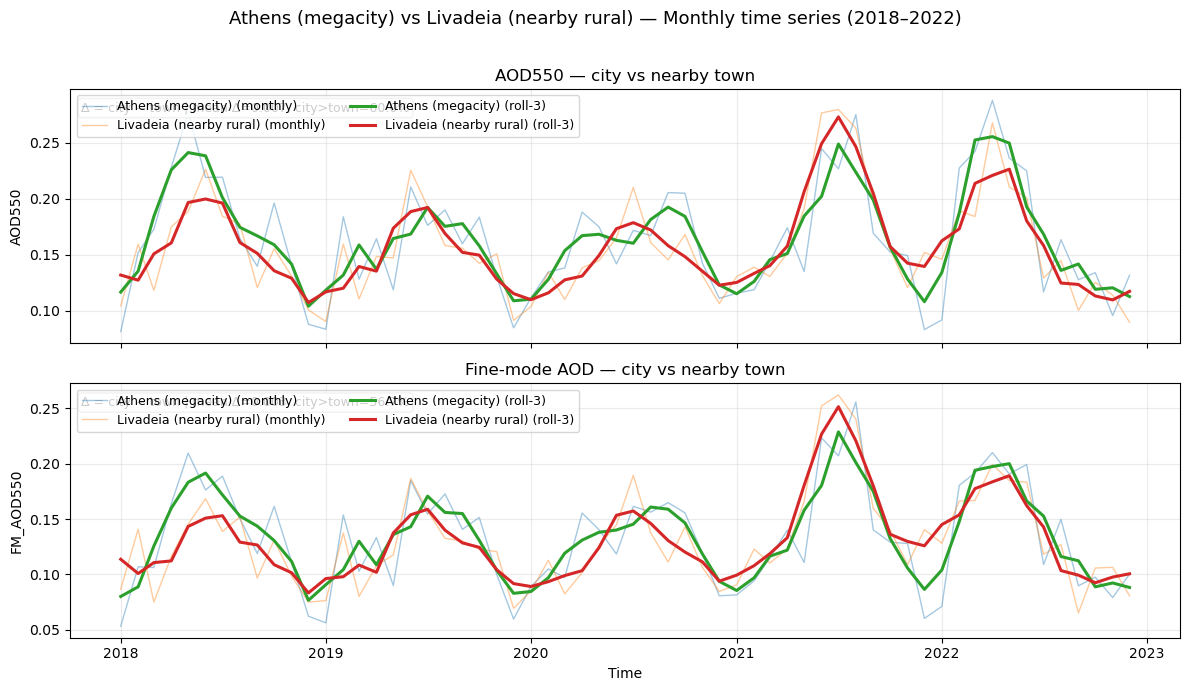

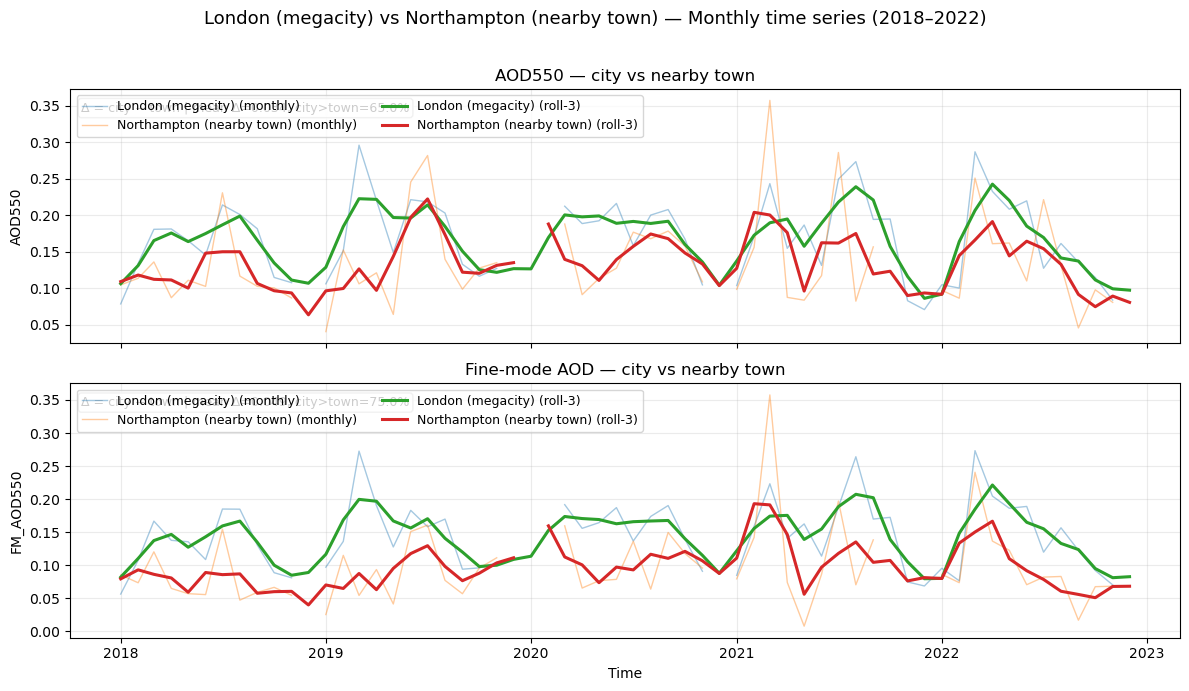

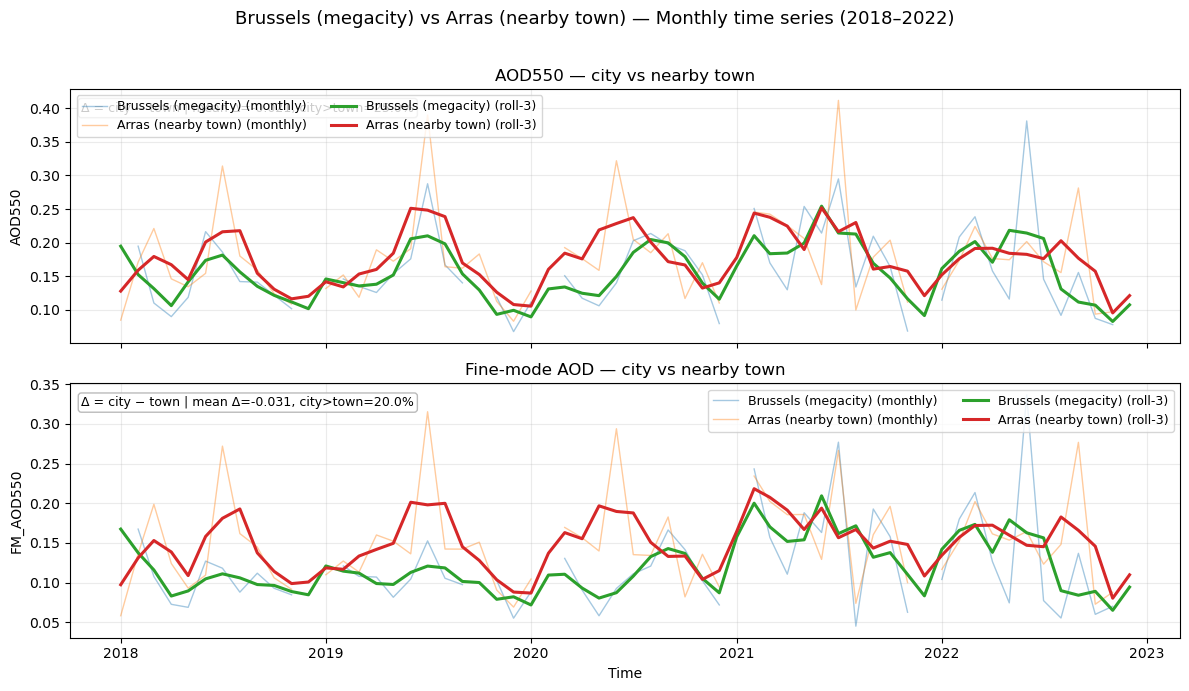

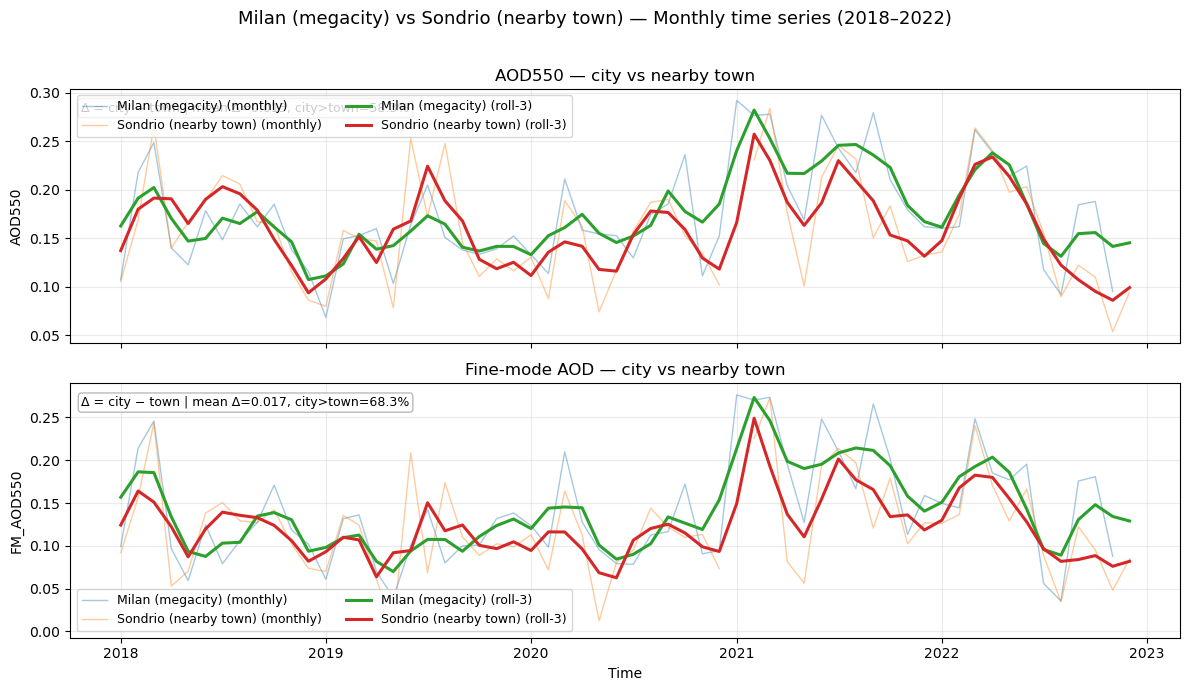

In [81]:

HALFWIN = 0.5   
for city, town in PAIRS:
    pair_df = build_pair_df(final_df, city, town, halfwin=HALFWIN)
    fig = plot_pair_timeseries(pair_df, city, town, year_start=YEAR_START, year_end=YEAR_END)
    fname = f"timeseries_{city.split()[0]}_{town.split()[0]}_{YEAR_START}-{YEAR_END}.png"
   
    plt.show()


*Figure 1.* Monthly mean time series of AOD550 and FM_AOD550 for each megacity and its paired nearby town (Athens–Livadeia, London–Northampton, Brussels–Arras, Milan–Sondrio). Solid lines show the megacity, dashed lines the nearby town. These plots illustrate temporal variability.

#### Seasonal AOD & FM-AOD maps (with city/rural markers)

Each panel shows seasonal means (DJF, MAM, JJA, SON) for total AOD and fine-mode AOD. Triangles mark city AOIs their rural references. These maps provide the regional context for the urban–rural time-series and enhancement analyses.

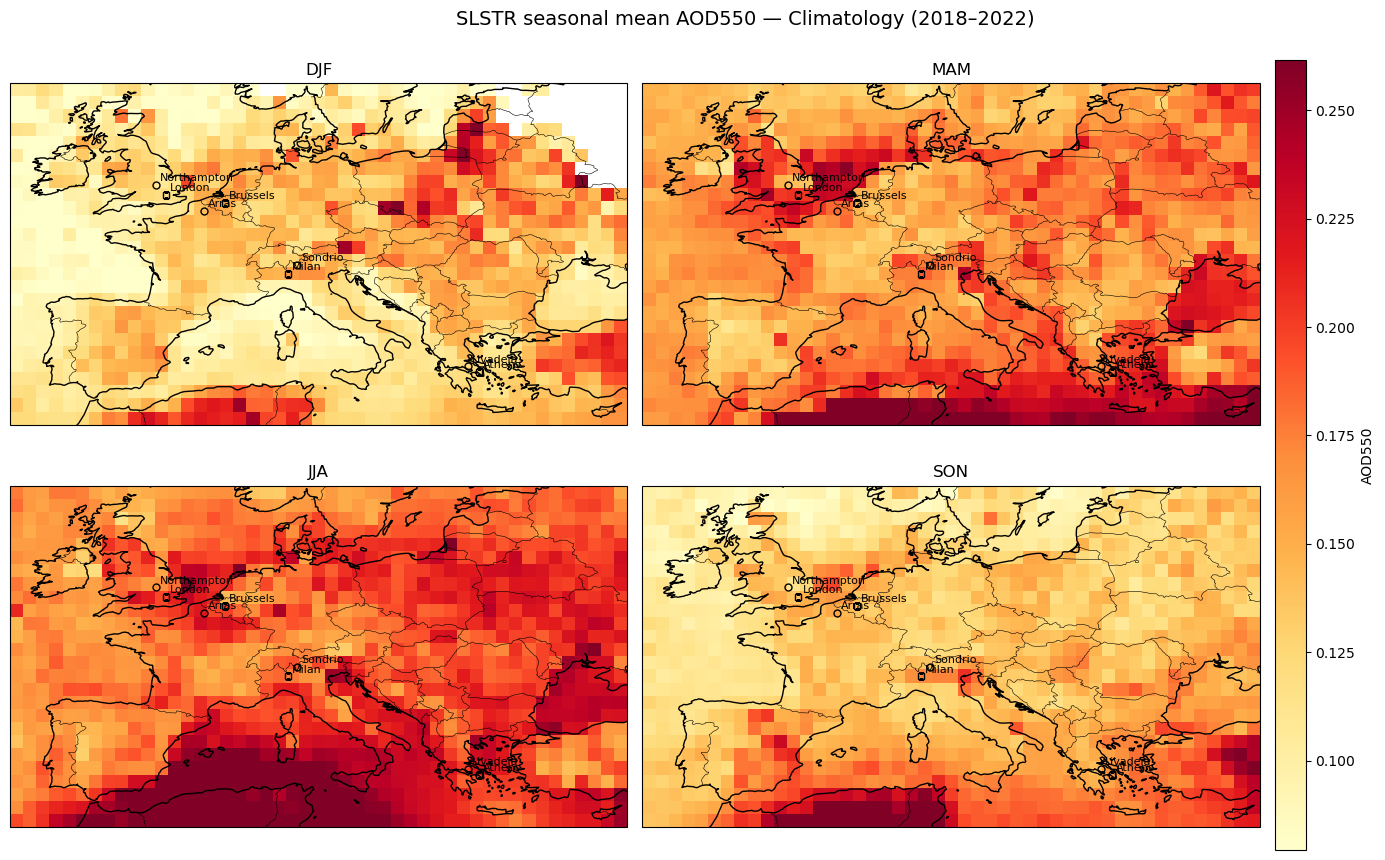

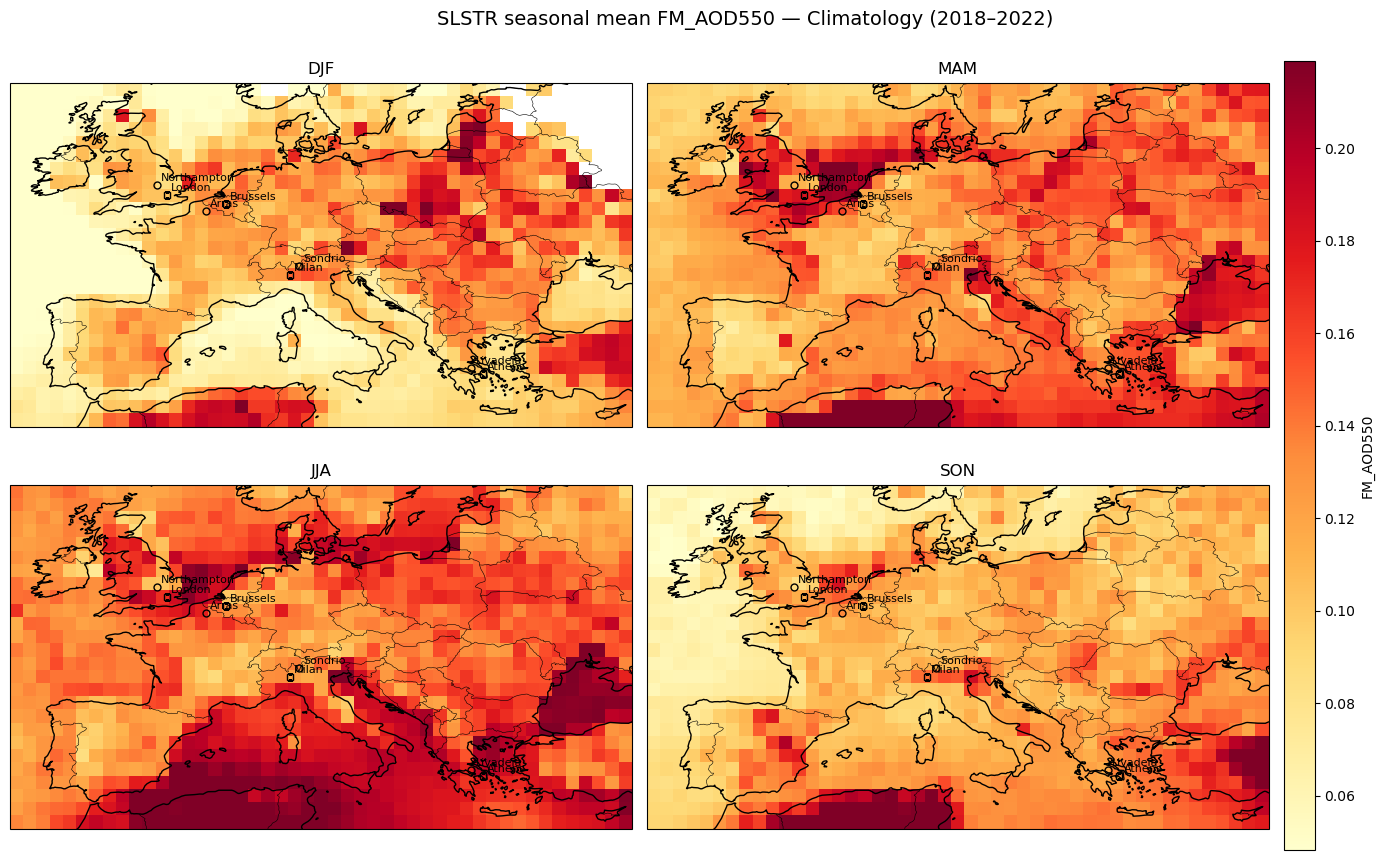

In [14]:
for var in ("AOD550", "FM_AOD550"):

    vals = seasonal[var].to_numpy()
    vmin = np.nanpercentile(vals, 5)
    vmax = np.nanpercentile(vals, 95)

    fig = plot_seasonal_maps(
    seasonal,
    var=var,
    season_year=None,
    vmin=vmin,
    vmax=vmax,
    extent=EUROPE_EXTENT,
    title_suffix=f"({YEAR_START}–{YEAR_END})",
    cmap="YlOrRd"   
)
    plt.show()


*Figure 2.* Seasonal AOD and Fine-Mode AOD (550 nm) over the Eastern Mediterranean, 2018–2023 (1°).

#### Focused seasonal map plots of AOD550 and FM_AOD550 for megacity–town pairs

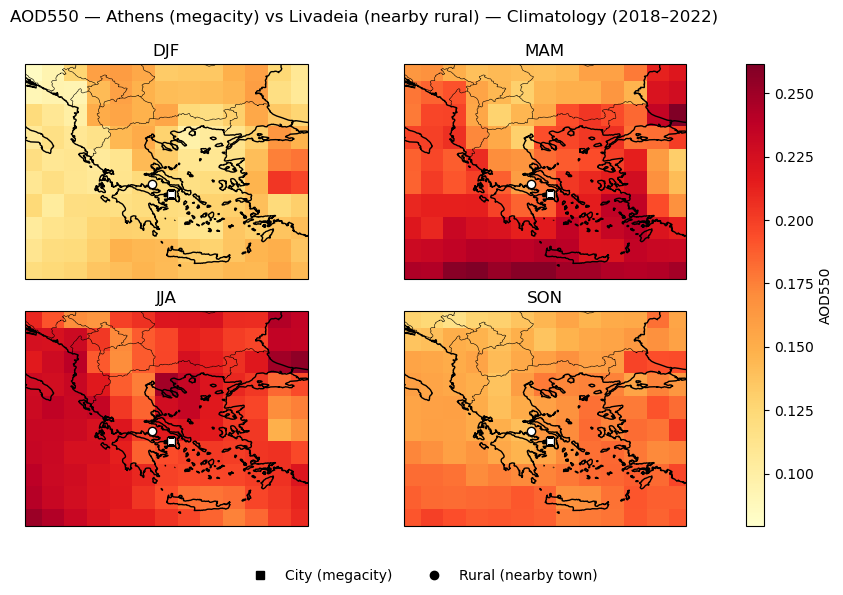

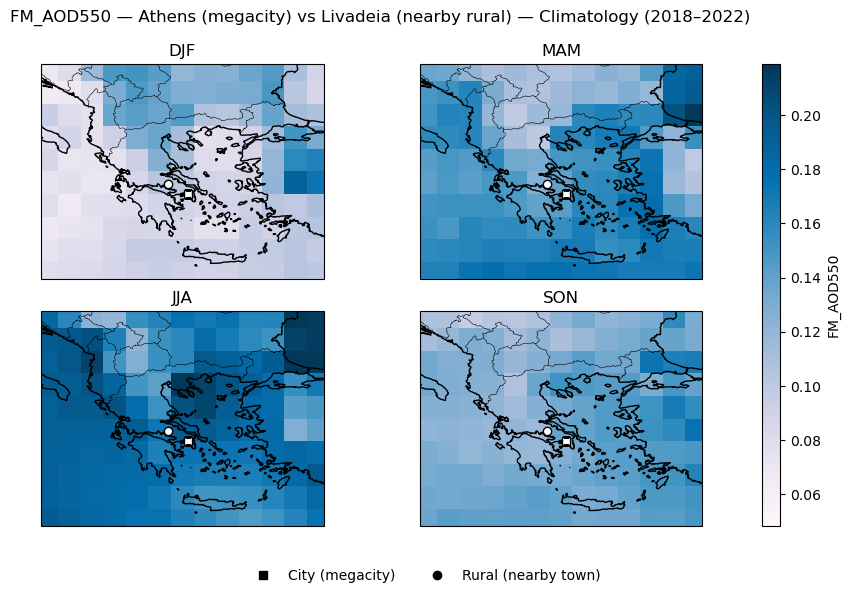

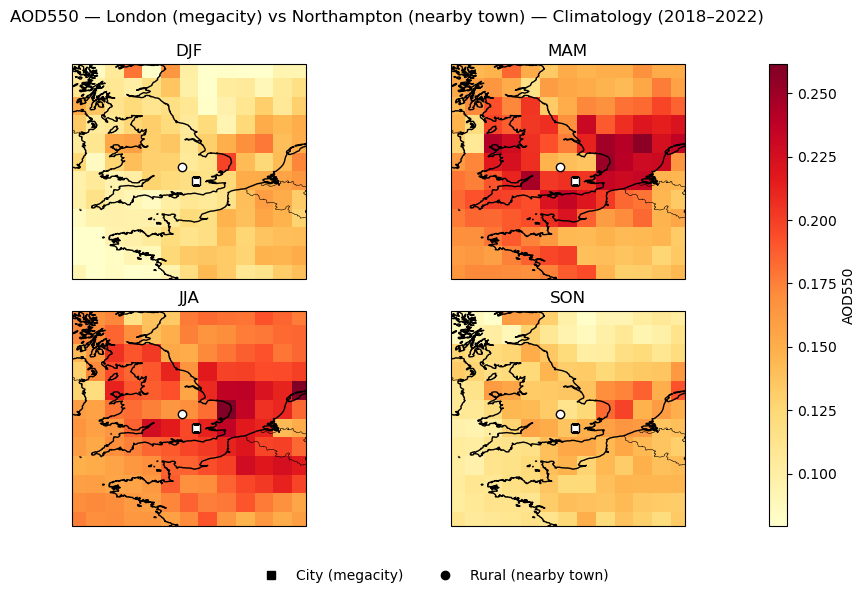

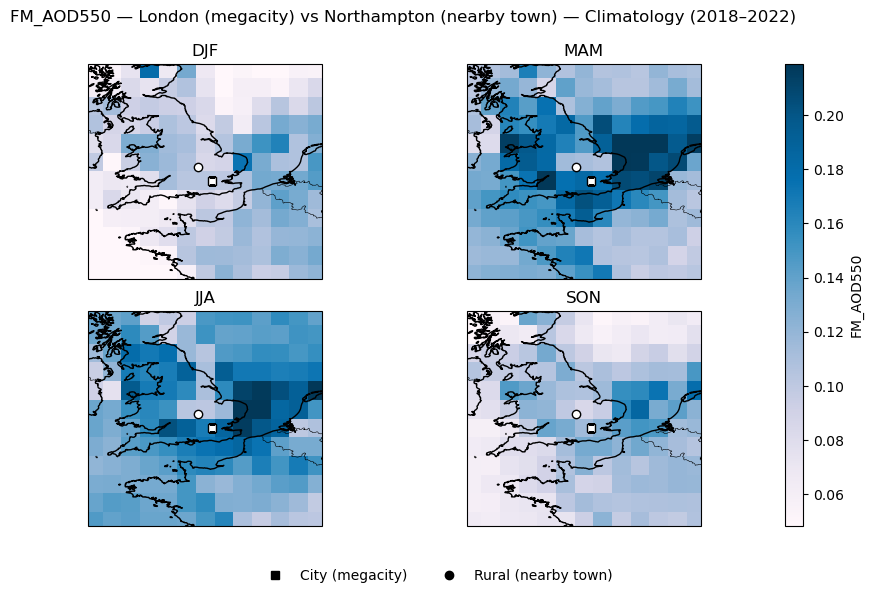

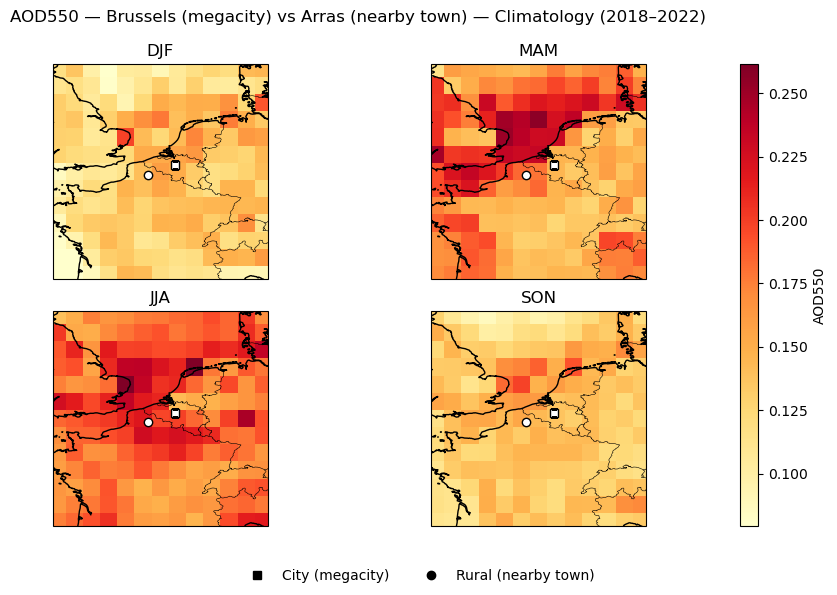

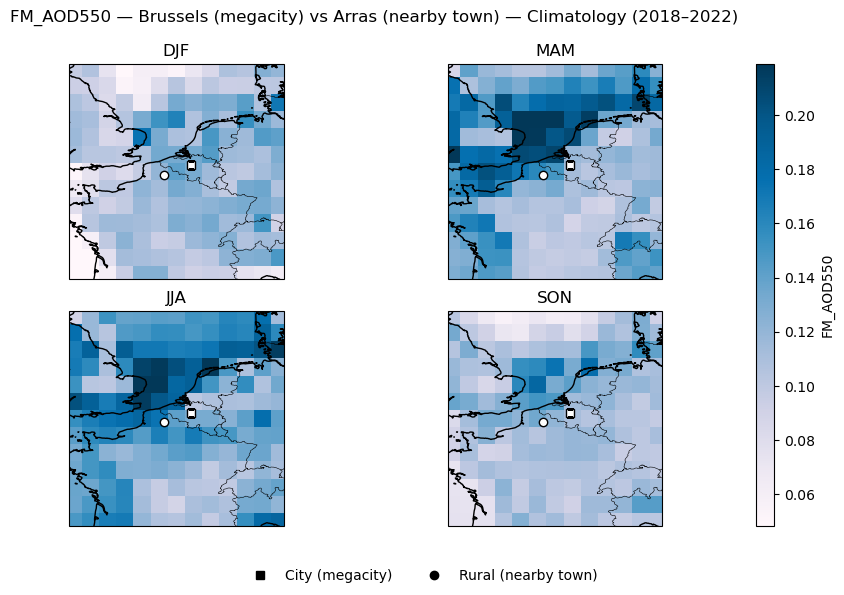

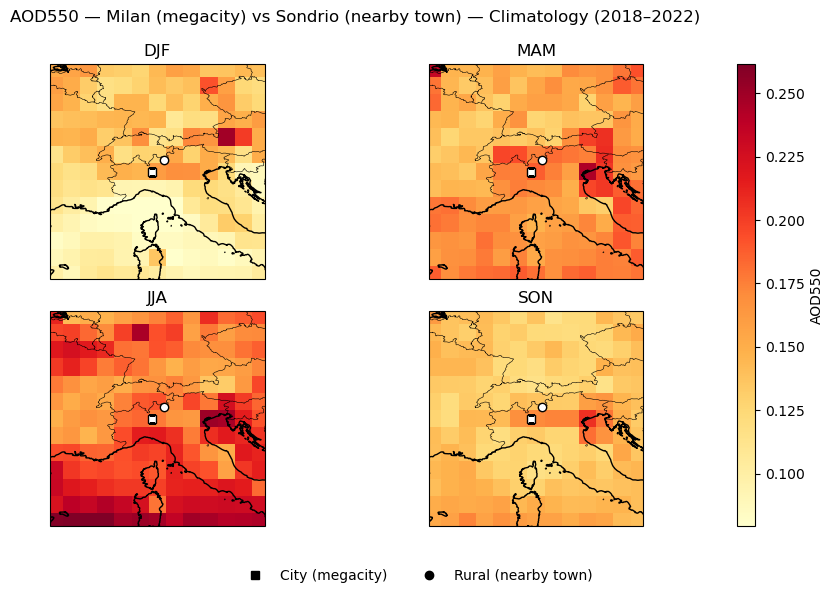

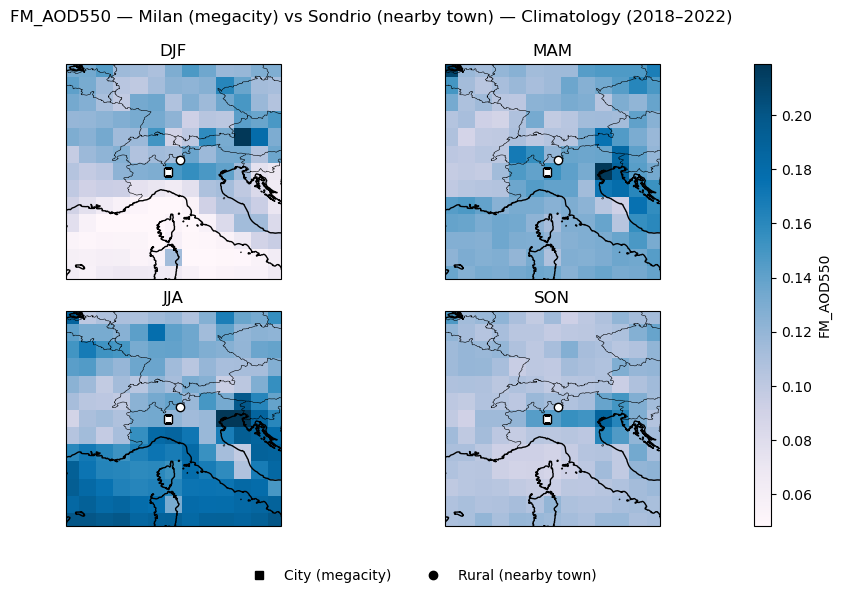

In [54]:
for pair in PAIRS:

    fig, extent = plot_pair_focus(pair, var="AOD550", cmap="YlOrRd",
                                  vmin=aod_vmin, vmax=aod_vmax, pad_deg=6.0)
   
    plt.show()
    fig, extent = plot_pair_focus(pair, var="FM_AOD550", cmap="PuBu",
                                  vmin=fm_vmin, vmax=fm_vmax, pad_deg=6.0)

    plt.show()

*Figure 3.* Focused seasonal map plots of AOD550 and FM_AOD550 for megacity–town pairs.

(section-4)=
### Take-Home Messages

- Seasonal cycles (e.g. summer peaks) dominate over city–rural differences.

  
- Fine-mode AOD (fm_aod550) does not consistently show higher values over cities, highlighting the challenge of using satellite AOD as a direct proxy for local pollution.

- Interpretation of urban–rural contrast in the AOD values requires caution, as meteorology, transport, and averaging effects can mask local signals.

- A small data gap is present for Northampton due to SLSTR data unavailability; while this reduces seasonal coverage, the available records still capture the main seasonal cycle and trends.

## ℹ️ If you want to know more
### Key Resources

• Aerosol properties gridded data from 1995 to present derived from satellite observations:

https://cds.climate.copernicus.eu/datasets/satellite-aerosol-properties?tab=overview

Code libraries used:

• C3S EQC custom function, c3s_eqc_automatic_quality_control, prepared by B-Open

### References

**[[1]](https://pubmed.ncbi.nlm.nih.gov/19603734/)** Hoff, R. M., & Christopher, S. A. (2009). *Remote sensing of particulate pollution from space: have we reached the promised land?* *Journal of the Air & Waste Management Association*, 59(6), 645–675. https://pubmed.ncbi.nlm.nih.gov/19603734/

**[[2]](https://health.hub.copernicus.eu/air-pollution-nearly-everyone-europe-breathing-bad-air-deutsche-welle)** *Air pollution: Nearly everyone in Europe is breathing bad air — Deutsche Welle (via Copernicus Health Hub)*